In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from IPython.display import clear_output

# Load Data

In [2]:
# Load dataset
data = pd.read_csv('../data/salary_data_pau_cleaned_small.csv')

## Create tensor

In [3]:
X = data.drop('Salary', axis=1)
y = data['Salary']

In [4]:
import pickle
with open("../streamlit-app/models/preprocessing_pipeline.pkl", "rb") as f:
    prepocessor = pickle.load(f)

# columns = data.columns
X = prepocessor.transform(X)
# X = pd.DataFrame(prepocessed_data)

In [5]:
# Dividir en conjunto de entrenamiento y validación y test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [6]:
# # Escalar los datos
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)


In [7]:
# Convertir a nd array
# X_train = X_train.values
# X_val = X_val.values
# X_test = X_test.values

In [8]:
# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Modeling

In [9]:
# Definir el modelo de red neuronal
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(7, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
# Inicializar modelo, pérdida y optimizador
model = RegressionNN()
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
train_loss_values = []
val_loss_values = []

In [12]:
# Entrenamiento del modelo
epochs = 50000  # Ajusta según tu caso
log_interval = 500

for epoch in range(epochs):
    # --- TRAIN PHASE ---
    model.train()
    optimizer.zero_grad()

    # 1) Forward (asegúrate de pasar las 2 entradas: X, job_title)
    predictions = model(X_train_tensor)
    
    # 2) Cálculo de la pérdida en entrenamiento
    train_loss = criterion(predictions, y_train_tensor)

    # 3) Backprop
    train_loss.backward()

    # 4) Actualización de parámetros
    optimizer.step()
    
    # --- VALIDATION PHASE (cada X iteraciones) ---
    if (epoch + 1) % log_interval == 0:
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor)

        # Almaceno valores de pérdida para gráficas
        train_loss_values.append(train_loss.item())
        val_loss_values.append(val_loss.item())

        # Mostrar progreso
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss.item():.4f} "
              f"Val Loss: {val_loss.item():.4f}")

        # (Opcional) Gráfica de pérdidas en tiempo real
        fig = plt.figure()
        plt.plot(train_loss_values[-50:], label='Train Loss')
        plt.plot(val_loss_values[-50:], label='Val Loss')
        plt.legend()
        plt.title("MAE Loss")
        plt.show()
        clear_output(wait=True)

KeyboardInterrupt: 

## Evaluación

In [ ]:
# Evaluación del modelo
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

    for i,j in zip(y_pred_test, y_test_tensor):
        print(i,j)

Test Loss: 11502.7920
tensor([133420.4375]) tensor([100000.])
tensor([72722.8516]) tensor([65000.])
tensor([54238.9688]) tensor([40000.])
tensor([163763.0781]) tensor([120177.])
tensor([140012.1406]) tensor([140000.])
tensor([68087.7422]) tensor([55000.])
tensor([169947.0781]) tensor([160000.])
tensor([120254.3516]) tensor([120000.])
tensor([170348.9219]) tensor([148446.])
tensor([71581.9609]) tensor([72000.])
tensor([169947.0781]) tensor([170000.])
tensor([176874.7812]) tensor([195000.])
tensor([132183.2812]) tensor([180000.])
tensor([183022.9688]) tensor([187120.])
tensor([57063.5508]) tensor([60000.])
tensor([166105.8906]) tensor([170000.])
tensor([185128.1406]) tensor([195000.])
tensor([127538.4297]) tensor([105000.])
tensor([190807.7031]) tensor([190000.])
tensor([90848.3359]) tensor([95000.])
tensor([55206.5195]) tensor([50000.])
tensor([139997.9531]) tensor([140000.])
tensor([128651.6406]) tensor([120000.])
tensor([183701.7188]) tensor([150534.])
tensor([189997.5312]) tensor([19

## Inferencia

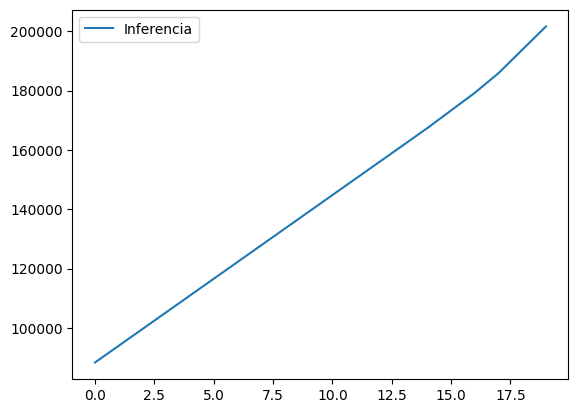

In [21]:
X_inferencia = [[32.0+i, "Female", "Bachelor's", "Software Engineer", 5.0+i, "Regular", "Software & IT"] for i in range(20)]
X_inferencia = pd.DataFrame(X_inferencia, columns=["Age", "Gender", "Education Level", "Job Title", "Years of Experience", "Job Category", "Job Type"])
X_inferencia_preprocessed = prepocessor.transform(X_inferencia)
X_inferencia_tensor = torch.tensor(X_inferencia_preprocessed, dtype=torch.float32)

model.eval()
with torch.no_grad():
    y_inferencia = model(X_inferencia_tensor)

# Plot the tensor
fig = plt.figure()
plt.plot(y_inferencia, label='Inferencia')
plt.legend()
plt.show()

## Save

In [ ]:
# Suponiendo que ya tienes un modelo entrenado
torch.save(model.state_dict(), '../streamlit-app/models/regression_nn.pth')